# M5 multi-step forecasting

In [73]:
"""Importing packages"""
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.special import binom, factorial
from sklearn.cluster import KMeans
from scipy.optimize import minimize

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor as lgb
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2
from sklearn.linear_model import LassoCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from rbfdiff import *

import time

#Set random seed
random.seed(42)
np.random.seed(42)
tf.compat.v1.reset_default_graph()
tf.compat.v2.random.set_seed(42)

In [74]:
"""Function definitions"""

def reshape_timeseries(y_series, n_lags):
    """
    This function reshapes a timeseries into input-output pairs {Xtrain,ytrain}
    y_series: input timeseries
    n_lags: number of lags or lookback window of the timeseries
    """
    y_series = list(y_series)
    X_train = []
    y_train = []
    for i in range(n_lags, len(y_series)):
        ar = y_series[i-n_lags: i]
        X_train.append(ar)
        y_train.append(y_series[i])
    return np.array(X_train).reshape(-1,n_lags), np.array(y_train).reshape(-1,1)

def difference(original_series): 
    """
    This function tests for stationarity on the timeseries using the augmented Dickey-Fuller test.
    Non-stationary timeseries are differenced incrementally, and the stationarity test performed.
    
    original_series: input original timeseries data
    stationary_series: output stationary timeseries
    first_values: first values of the timeseries required to recover the original series; 
    the length of first_values is equal to the differencing order
    """
    first_values = []; stationary_series = original_series
    for i in range(0, 11):
        if i == 0:
            series_to_test = original_series
        else:
            series_to_test = series_to_test.diff(1)[1:]
        first_values.append(series_to_test.iloc[0])
        stat_result = adfuller(series_to_test) #Check stationarity
        pval = stat_result[1] #p-value
        if pval <= 0.05:
            stationary_series = series_to_test
            break       
    first_values = np.flip(first_values[0:-1])
    return stationary_series, first_values

def integrate(differenced_series, first_values): 
    """
    This function reverse-differences a differenced timeseries to recover the original timseries
    
    differenced_series: input differenced timeseries
    original_series: output original timeseries
    """
    diff_order = len(first_values)
    original_series = differenced_series.flatten()
    if diff_order == 0:
        original_series = differenced_series.flatten()
    else:
        for i in range(diff_order):
            original_series = np.column_stack((first_values[i].reshape(1,1), (np.cumsum(original_series) \
              + first_values[i]).reshape(1,-1))).flatten()      
    return original_series

In [75]:
"""
M5 data forecasting
"""
level12_data = pd.read_csv('sales_train_evaluation.csv', low_memory = False)
level3_data = level12_data.groupby('store_id').sum()

In [76]:
series_id = 1
num_test = 28
horizon = num_test
nlags = 14

In [77]:
y = level3_data.iloc[series_id,:].values

n = len(y)

num_train = n - num_test

y_val = y[-num_test:] #test sequence
ytrain = y[0: num_train] #training sequence


"""Preprocessing"""

# Differencing timeseries to make stationary
ytrain_stationary, first_vals = difference(pd.Series(ytrain))

# Rescaling timeseries
scaler = StandardScaler().fit(ytrain_stationary.values.reshape(-1,1))

ytrain_scaled = scaler.transform(ytrain_stationary.values.reshape(-1,1))

# Reshaping timeseries into {input, output} pairs
X_train, y_train = reshape_timeseries(list(ytrain_scaled.flatten()), nlags)

denom = np.mean(np.diff(ytrain.flatten())**2) #denominator in RMSSE formula 

In [78]:
y = level3_data.iloc[series_id,:].values

In [79]:
#Fitting gradient boosted tree
lgbm = lgb(random_state=42).fit(X_train, y_train.flatten())

In [80]:
def multistep_predict(y_train, horizon):
    """
    This function provides multistep predictions for a timeseries

    algorithm: an input string indicating what algorithm is being used for the predictions
    ypredicted: a predicted sequence whose length equals the forecast horizon
    """
    predicted_sequence = list(y_train.flatten())
    for i in range(horizon):
        lagged_input = predicted_sequence[-nlags:]
        xtest = np.array(lagged_input).reshape(1,-1)
        yest = lgbm.predict(xtest)
        predicted_sequence.append(yest)
    ypred = np.array(predicted_sequence[-horizon:])   
    return np.array(ypred)

In [81]:
ypred = multistep_predict(y_train, 28)

ybar = scaler.inverse_transform(ypred.reshape(-1,1))

train_test = np.column_stack((ytrain_stationary.values.reshape(1,-1), ybar.reshape(1,-1)))
y_pred = (integrate(train_test, first_vals))[-num_test:]

# Error metrics
rmsse = np.sqrt(MSE(y_val, y_pred)/denom)
r2 = R2(y_val, y_pred)
rmse = MSE(y_val, y_pred, squared=False)
mae = MAE(y_val, y_pred)

print(r2, rmsse)

0.6173452834042321 0.9289494432344643


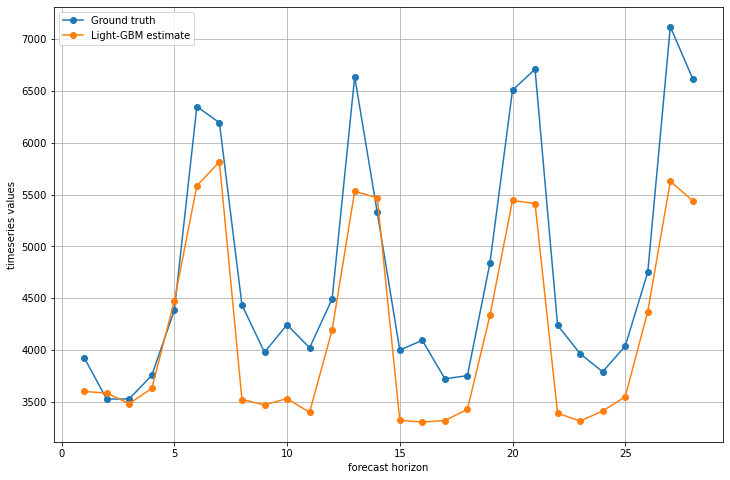

In [82]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1,29), y_val,'o-')
plt.plot(np.arange(1,29), y_pred,'o-')
plt.grid(True)
plt.xlabel('forecast horizon')
plt.ylabel('timeseries values')
plt.legend(['Ground truth','Light-GBM estimate'])
plt.show()

In [ ]:
### Validation set -- Consider using data around first prediction

## Confidence intervals

### ARIMA

In [ ]:
#train
arimaMdl = pm.auto_arima(ytrain, max_p=4, max_q=4,
           stepwise=True, suppress_warnings=True, error_action='ignore', random_state=42)

# predict
y_arima, conf_int = arimaMdl.predict(n_periods = num_test, return_conf_int=True)

# Error metrics
rmsse = np.sqrt(MSE(y_val, y_arima)/denom)
r2 = R2(y_val, y_arima)
rmse = MSE(y_val, y_arima, squared=False)
mae = MAE(y_val, y_arima)

print(r2, rmsse)

In [ ]:
#Plotting for the test dates 
yTest = pd.DataFrame(y_val)
yPred = pd.DataFrame(y_arima)
yLow = pd.Series(conf_int[:,0])
yHigh = pd.Series(conf_int[:,1])

plt.figure(figsize=(12, 8))
ax = yTest.plot(label = 'ground truth')
yPred.plot(ax = ax, label = 'predicted')
ax.fill_between(yTest.index,
                    yLow,
yHigh, color='k', alpha=.2)
ax.set_xlabel('horizon')
ax.set_ylabel('quantity')
plt.legend(['ground truth', 'predicted'])
plt.grid(True)
plt.show()

In [ ]:
#Facebook Prophet

### Gaussian Process Regression

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
gprMdl = GPR(kernel=RBF(np.ones([X_train.shape[1],])), random_state=42, normalize_y=True).fit(X_train, y_train)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
gprMdl = GPR(kernel=RBF(np.ones([X_train.shape[1],])), random_state=42, normalize_y=True).fit(X_train, y_train)

In [ ]:
def multistep_predict(mdl, y_train, horizon):
    """
    This function provides multistep predictions for a timeseries

    algorithm: an input string indicating what algorithm is being used for the predictions
    ypredicted: a predicted sequence whose length equals the forecast horizon
    """
    predicted_sequence = list(y_train.flatten())
    std_list = []
    for i in range(horizon):
        lagged_input = predicted_sequence[-nlags:]
        xtest = np.array(lagged_input).reshape(1,-1)
        yest, std = mdl.predict(xtest, return_std= True)
        predicted_sequence.append(yest)
        std_list.append(std)
    ypred = np.array(predicted_sequence[-horizon:])   
    return np.array(ypred).flatten(), std_list

In [ ]:
y_gpr, y_std = multistep_predict(gprMdl, y_train, 28)

ybar = scaler.inverse_transform(ypred.reshape(-1,1))

y_std = scaler.inverse_transform(np.array(y_std).reshape(-1,1)).flatten()

train_test = np.column_stack((ytrain_stationary.values.reshape(1,-1), ybar.reshape(1,-1)))
y_gpr = (integrate(train_test, first_vals))[-num_test:]

# Error metrics
rmsse = np.sqrt(MSE(y_val, y_gpr)/denom)
r2 = R2(y_val, y_gpr)
rmse = MSE(y_val, y_gpr, squared=False)
mae = MAE(y_val, y_gpr)

print(r2, rmsse)

In [ ]:
#Plotting for the test dates 
yTest = pd.DataFrame(y_val)
yPred = pd.DataFrame(y_gpr)
yLow = pd.Series(y_gpr - 2*y_std)
yHigh = pd.Series(y_gpr + 2*y_std)

plt.figure(figsize=(12, 8))
ax = yTest.plot(label = 'ground truth')
yPred.plot(ax = ax, label = 'predicted')
ax.fill_between(yTest.index,
                    yLow,
yHigh, color='k', alpha=.2)
ax.set_xlabel('horizon')
ax.set_ylabel('quantity')
plt.legend(['ground truth', 'predicted'])
plt.grid(True)
plt.show()

In [ ]:
# Statistical assumptions

In [ ]:
# Random initialisations

## Explanatory variables

In [6]:
calendar = pd.read_csv('calendar.csv', low_memory = False)
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [7]:
sell_prices = pd.read_csv('sell_prices.csv', low_memory = False)
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [8]:
cal_prices = calendar.merge(sell_prices, on='wm_yr_wk', how='inner')
cal_prices

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,store_id,item_id,sell_price
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_008,0.46
1,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_009,1.56
2,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_010,3.17
3,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_012,5.98
4,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_015,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47735392,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,WI_3,FOODS_3_823,2.98
47735393,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,WI_3,FOODS_3_824,2.48
47735394,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,WI_3,FOODS_3_825,3.98
47735395,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,WI_3,FOODS_3_826,1.28


In [9]:
agg_dict = {column: 'last' for column in cal_prices.columns}
agg_dict['sell_price'] = 'mean'
cal_prices_agg = cal_prices.groupby(['d','store_id']).agg(agg_dict).reset_index(drop=True)
cal_prices_agg

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,store_id,item_id,sell_price
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,CA_1,FOODS_3_824,4.081071
1,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,CA_2,FOODS_3_825,4.226280
2,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,CA_3,FOODS_3_824,4.109869
3,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,CA_4,FOODS_3_825,4.024255
4,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,TX_1,FOODS_3_825,3.931017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19685,2013-10-23,11339,Wednesday,5,10,2013,d_999,NaN,NaN,NaN,NaN,0,0,0,TX_2,FOODS_3_826,4.362012
19686,2013-10-23,11339,Wednesday,5,10,2013,d_999,NaN,NaN,NaN,NaN,0,0,0,TX_3,FOODS_3_826,4.370638
19687,2013-10-23,11339,Wednesday,5,10,2013,d_999,NaN,NaN,NaN,NaN,0,0,0,WI_1,FOODS_3_826,4.393769
19688,2013-10-23,11339,Wednesday,5,10,2013,d_999,NaN,NaN,NaN,NaN,0,0,0,WI_2,FOODS_3_826,4.383184


In [10]:
sales_agg = level3_data.transpose().reset_index()
sales_agg

store_id,index,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
0,d_1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
1,d_2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
2,d_3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
3,d_4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
4,d_5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132
...,...,...,...,...,...,...,...,...,...,...,...
1936,d_1937,3995,3789,5375,2519,3147,3518,3710,3242,4533,3268
1937,d_1938,4136,4037,5580,2544,2748,3126,3288,3478,4628,3398
1938,d_1939,4433,4751,5542,2704,3664,4249,4390,3813,4880,4126
1939,d_1940,5764,7120,7073,3146,4167,4802,4712,5002,5213,4519


In [21]:
store_data_dict = {}

for store_id in sales_agg.columns[1:]:
    #print(store_id)
    store_data = sales_agg[['index',store_id]].merge(cal_prices_agg[cal_prices_agg['store_id']==store_id], \
                                                     left_on='index', right_on='d', how='inner').fillna(-1)
    
    store_data = pd.get_dummies(store_data, columns=['event_type_1', 'event_type_2'], drop_first=True)
    
    store_data['snap'] = store_data['snap_'+store_id[0:2]]
    
    store_data = store_data.drop(columns= \
     ['index','date','wm_yr_wk','weekday','d','event_name_1','event_name_2','snap_TX','snap_WI','snap_CA','store_id','item_id'])
    
    store_data_dict[store_id] = store_data

In [23]:
ca1_data = store_data_dict['CA_2']
ca1_data

,CA_2,wday,month,year,sell_price,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,snap
0,3494,1,1,2011,4.226280,0,0,0,0,0,0,0
1,3046,2,1,2011,4.226280,0,0,0,0,0,0,0
2,2121,3,1,2011,4.226280,0,0,0,0,0,0,0
3,2324,4,2,2011,4.226280,0,0,0,0,0,0,1
4,1942,5,2,2011,4.226280,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1936,3789,5,5,2016,4.486182,0,0,0,0,0,0,0
1937,4037,6,5,2016,4.486182,0,0,0,0,0,0,0
1938,4751,7,5,2016,4.486182,0,0,0,0,0,0,0
1939,7120,1,5,2016,4.486274,0,0,0,0,0,0,0


In [13]:
ca1_data['event_type_1'].unique()

array([-1, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [14]:
ca1_data = pd.get_dummies(ca1_data, columns=['event_type_1', 'event_type_2'], drop_first=True)
ca1_data

,index,CA_1,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,...,snap_WI,store_id,item_id,sell_price,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious
0,d_1,4337,2011-01-29,11101,Saturday,1,1,2011,d_1,-1,...,0,CA_1,FOODS_3_824,4.081071,0,0,0,0,0,0
1,d_2,4155,2011-01-30,11101,Sunday,2,1,2011,d_2,-1,...,0,CA_1,FOODS_3_824,4.081071,0,0,0,0,0,0
2,d_3,2816,2011-01-31,11101,Monday,3,1,2011,d_3,-1,...,0,CA_1,FOODS_3_824,4.081071,0,0,0,0,0,0
3,d_4,3051,2011-02-01,11101,Tuesday,4,2,2011,d_4,-1,...,0,CA_1,FOODS_3_824,4.081071,0,0,0,0,0,0
4,d_5,2630,2011-02-02,11101,Wednesday,5,2,2011,d_5,-1,...,1,CA_1,FOODS_3_824,4.081071,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,d_1937,3995,2016-05-18,11616,Wednesday,5,5,2016,d_1937,-1,...,0,CA_1,FOODS_3_827,4.488967,0,0,0,0,0,0
1937,d_1938,4136,2016-05-19,11616,Thursday,6,5,2016,d_1938,-1,...,0,CA_1,FOODS_3_827,4.488967,0,0,0,0,0,0
1938,d_1939,4433,2016-05-20,11616,Friday,7,5,2016,d_1939,-1,...,0,CA_1,FOODS_3_827,4.488967,0,0,0,0,0,0
1939,d_1940,5764,2016-05-21,11617,Saturday,1,5,2016,d_1940,-1,...,0,CA_1,FOODS_3_827,4.487904,0,0,0,0,0,0


In [15]:
ca1_data = ca1_data.drop(columns=['index','date','wm_yr_wk','weekday','d','event_name_1','event_name_2','snap_TX','snap_WI','store_id','item_id'])
ca1_data

,CA_1,wday,month,year,snap_CA,sell_price,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious
0,4337,1,1,2011,0,4.081071,0,0,0,0,0,0
1,4155,2,1,2011,0,4.081071,0,0,0,0,0,0
2,2816,3,1,2011,0,4.081071,0,0,0,0,0,0
3,3051,4,2,2011,1,4.081071,0,0,0,0,0,0
4,2630,5,2,2011,1,4.081071,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1936,3995,5,5,2016,0,4.488967,0,0,0,0,0,0
1937,4136,6,5,2016,0,4.488967,0,0,0,0,0,0
1938,4433,7,5,2016,0,4.488967,0,0,0,0,0,0
1939,5764,1,5,2016,0,4.487904,0,0,0,0,0,0


In [83]:
X, y = reshape_timeseries(ca1_data.iloc[:,0].values[0:-num_test], nlags)

denom = np.mean(np.diff(ca1_data.iloc[:,0].values[0:-num_test])**2) #denominator in RMSSE formula 
y_val = ca1_data.iloc[:,0].values[-num_test:]

expl_X = []
expl_y = []
for column in ca1_data.columns[1:]:
    X_expl, y_expl = reshape_timeseries(ca1_data[column].values, nlags)
    expl_X.append(X_expl)
    expl_y.append(y_expl)
expl = np.column_stack((np.column_stack(tuple(expl_X)), np.column_stack(tuple(expl_y))))

expl_train = expl[0:-num_test,:]
expl_test = expl[-num_test:,:]

In [84]:
ytrain = y.flatten()
Xtrain = np.column_stack((X, expl_train))
Xtrain.shape

(1899, 179)

In [85]:
ytrain.shape

(1899,)

In [86]:
#Fitting gradient boosted tree
lgbm = lgb(random_state=42).fit(Xtrain, ytrain.flatten())

In [87]:
def multistep_predict(mdl, y_train, horizon):
    """
    This function provides multistep predictions for a timeseries

    algorithm: an input string indicating what algorithm is being used for the predictions
    ypredicted: a predicted sequence whose length equals the forecast horizon
    """
    predicted_sequence = list(y_train.flatten())
    std_list = []
    for i in range(horizon):
        lagged_input = predicted_sequence[-nlags:]
        xtest = np.column_stack((np.array(lagged_input).reshape(1,-1), expl_test[i,:].reshape(1,-1)))
        yest = mdl.predict(xtest)
        predicted_sequence.append(yest)
    ypred = np.array(predicted_sequence[-horizon:])   
    return np.array(ypred).flatten()

In [88]:
y_pred = multistep_predict(lgbm, ytrain, horizon)

# Error metrics
rmsse = np.sqrt(MSE(y_val, y_pred)/denom)
r2 = R2(y_val, y_pred)
rmse = MSE(y_val, y_pred, squared=False)
mae = MAE(y_val, y_pred)

print(r2, rmsse)

0.7260786021197958 0.7859619527887439


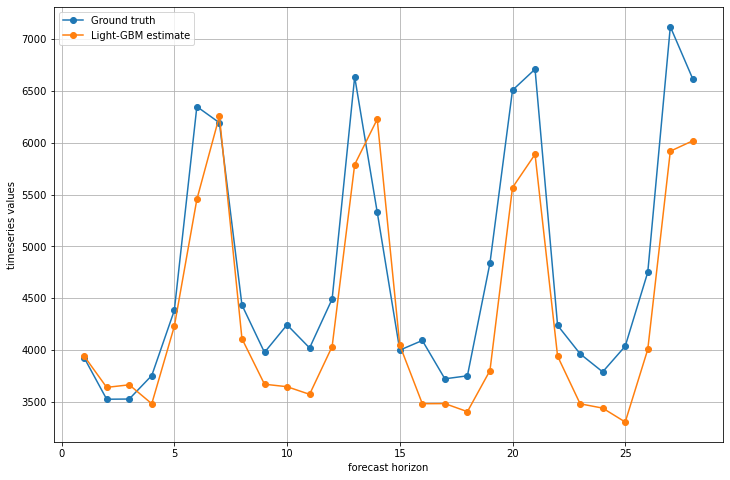

In [89]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1,29), y_val,'o-')
plt.plot(np.arange(1,29), y_pred,'o-')
plt.grid(True)
plt.xlabel('forecast horizon')
plt.ylabel('timeseries values')
plt.legend(['Ground truth','Light-GBM estimate'])
plt.show()

### Training loop

In [ ]:
epochs = 500
num_ensembles = 10 #MLP/ LSTM ensembles
nlags = 14
num_centres = 28 # number of hidden layer nodes/ number of RBF centres
num_test = 28
order_opt = 1
p_closest = 20
num_iter = 100

In [ ]:
"""Function definitions"""

def reshape_timeseries(y_series, n_lags):
    """
    This function reshapes a timeseries into input-output pairs {Xtrain,ytrain}
    y_series: input timeseries
    n_lags: number of lags or lookback window of the timeseries
    """
    X_train = []
    y_train = []
    for i in range(n_lags, len(y_series)):
        ar = y_series[i-n_lags: i]
        X_train.append(ar)
        y_train.append(y_series[i])
    return np.array(X_train).reshape(-1,n_lags), np.array(y_train).reshape(-1,1)

def difference(original_series): 
    """
    This function tests for stationarity on the timeseries using the augmented Dickey-Fuller test.
    Non-stationary timeseries are differenced incrementally, and the stationarity test performed.
    
    original_series: input original timeseries data
    stationary_series: output stationary timeseries
    first_values: first values of the timeseries required to recover the original series; 
    the length of first_values is equal to the differencing order
    """
    first_values = []; stationary_series = original_series
    for i in range(0, 11):
        if i == 0:
            series_to_test = original_series
        else:
            series_to_test = series_to_test.diff(1)[1:]
        first_values.append(series_to_test.iloc[0])
        stat_result = adfuller(series_to_test) #Check stationarity
        pval = stat_result[1] #p-value
        if pval <= 0.05:
            stationary_series = series_to_test
            break       
    first_values = np.flip(first_values[0:-1])
    return stationary_series, first_values

def integrate(differenced_series, first_values): 
    """
    This function reverse-differences a differenced timeseries to recover the original timseries
    
    differenced_series: input differenced timeseries
    original_series: output original timeseries
    """
    diff_order = len(first_values)
    original_series = differenced_series.flatten()
    if diff_order == 0:
        original_series = differenced_series.flatten()
    else:
        for i in range(diff_order):
            original_series = np.column_stack((first_values[i].reshape(1,1), (np.cumsum(original_series) \
              + first_values[i]).reshape(1,-1))).flatten()      
    return original_series

def MLParchitecture():
    """
    This function builds an architecture for an MLP network, and returns the network model
    """
    model = keras.Sequential([
    layers.Dense(28, activation = 'sigmoid', input_shape=[X_train.shape[1]]),
    layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam()
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])       
    return model


def LSTMarchitecture():
    """
    This function builds an architecture for an LSTM network, and returns the network model
    """
    model = keras.Sequential([
    layers.LSTM(28, input_shape=(1, X_train.shape[1])),
    layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam()
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])       
    return model


def multistep_predict(algorithm):
    """
    This function provides multistep predictions for a timeseries

    algorithm: an input string indicating what algorithm is being used for the predictions
    ypredicted: a predicted sequence whose length equals the forecast horizon
    """
    for i in range(num_test):
        lagged_input = predicted_sequence[-nlags:]
        xtest = np.array(lagged_input)
        if algorithm == 'diffnet':
            yest = testRBFDiffNet(xtest.reshape(1,-1), weights, centres, betas)[0][0]
        elif algorithm == 'rbfn':
            yest = testRBFN(xtest.reshape(1,-1), centres_base, betas_base, rbfMdl, True)[0]
        elif algorithm == 'mlp':
            yest = model.predict(xtest.reshape(1,-1)).flatten()[0]
        elif algorithm == 'lgbm':
            yest = lgbm.predict(xtest.reshape(1,-1))
        elif algorithm == 'lstm':
            yest = model.predict(xtest.reshape(1,1,-1)).flatten()[0]
        predicted_sequence.append(yest)
    ypred = np.array(predicted_sequence[-num_test:])
    if algorithm == 'lstm':  
        ybar = scaler_lstm.inverse_transform(ypred.reshape(-1,1))
    else:
        ybar = scaler.inverse_transform(ypred.reshape(-1,1))
    train_test = np.column_stack((ytrain_stationary.values.reshape(1,-1), ybar.reshape(1,-1)))
    ypredicted = (integrate(train_test, first_vals))[-num_test:]
    return np.array(ypredicted)

In [ ]:
diffnet_results = []
rbfn_results = []
arima_results = []
mlp_results = []
lstm_results = []
lgbm_results = []

diffnet_time = []
rbfn_time = []
arima_time = []
mlp_time = []
lstm_time = []
lbgm_time = []

for series_id in range(level3_data.shape[0]):
    print('series', series_id + 1)

    y = level3_data.iloc[series_id,:].values 
    n = len(y)
    num_train = n - num_test
    
    ytest = y[-num_test:] #test sequence
    ytrain = y[0: num_train] #training sequence
    
    
    """Preprocessing"""
    # Differencing timeseries to make stationary
    ytrain_stationary, first_vals = difference(pd.Series(ytrain))

    # Rescaling timeseries
    scaler = StandardScaler().fit(ytrain_stationary.values.reshape(-1,1))
    scaler_lstm = MinMaxScaler(feature_range=(-1,1)).fit(ytrain_stationary.values.reshape(-1,1))    
    #scaling data to the range (-1,1) for the benefit of the tanh activation in LSTM block
    
    ytrain_scaled = scaler.transform(ytrain_stationary.values.reshape(-1,1))
    ytrain_lstm = scaler_lstm.transform(ytrain_stationary.values.reshape(-1,1))

    # Reshaping timeseries into {input, output} pairs
    X_train, y_train = reshape_timeseries(list(ytrain_scaled.flatten()), nlags)
    X_train_lstm, y_train_lstm = reshape_timeseries(list(ytrain_lstm.flatten()), nlags)
     
    denom = np.mean(np.diff(ytrain.flatten())**2) #denominator in RMSSE formula 
    
    """RBF-DiffNet"""
    # train
    start_time = time.time()
    weights, centres, betas = \
    trainRBFDiffNet(X_train, y_train, num_centres, nlags, order_opt, p_closest, num_iter)
    diffnet_time.append(time.time()-start_time)
    # predict
    predicted_sequence = list(y_train.flatten())
    yhat = multistep_predict('diffnet')
    # evaluate error
    rmsse = np.sqrt(MSE(yhat, ytest)/denom) #root mean squared scaled error
    diffnet_results.append(rmsse)
    print('diffnet rmsse: ' + str(rmsse))
    
    
    """Light-GBM"""
    #train
    start_time = time.time()
    lgbm = lgb(random_state=42).fit(X_train, y_train.flatten())
    lgbm_time.append(time.time()-start_time)
    #predict
    yhat_lgbm = multistep_predict('rbfn')
    rmsse = np.sqrt(MSE(yhat_lgbm, ytest)/denom)
    diffnet_results.append(rmsse)
    print('LGBM rmsse: ' + str(rmsse))
    
    
    """ARIMA"""
    # train
    start_time = time.time()
    arimaMdl = pm.auto_arima(ytrain, max_p=4, max_q=4,
               stepwise=True, suppress_warnings=True, error_action='ignore', random_state=42)
    arima_time.append(time.time()-start_time)
    # predict
    predicted_sequence = list(y_train.flatten())
    yhat_arima, conf_int = arimaMdl.predict(n_periods = num_test, return_conf_int=True)
    # evaluate error
    rmsse = np.sqrt(MSE(yhat_arima, ytest)/denom)
    arima_results.append(rmsse)
    print('arima rmsse: ' + str(rmsse))

    
    """normalised RBF network"""
    # train
    start_time = time.time()
    rbfMdl, centres_base, betas_base = trainRBFN(X_train, y_train, num_centres, p_closest, True)
    rbfn_time.append(time.time()-start_time)
    # predict
    predicted_sequence = list(y_train.flatten())
    yhat_rbfn = multistep_predict('rbfn')
    # evaluate error
    rmsse = np.sqrt(MSE(yhat_rbfn, ytest)/denom)
    rbfn_results.append(rmsse)
    print('RBFN rmsse: ' + str(rmsse))
    
    
    """MLP ensemble"""
    # train
    start_time = time.time()
    mlp_mdls = []
    for j in range(num_ensembles):
        print('training MLP ' + str(j+1))
        model = MLParchitecture()
        history = model.fit(X_train, y_train, epochs=epochs, verbose=0)
        mlp_mdls.append(model)
    mlp_time.append(time.time()-start_time)
    # predict
    yhat_mlp = []
    for j in range(num_ensembles):
        predicted_sequence = list(y_train.flatten())
        model  = mlp_mdls[j]
        y_predicted = multistep_predict('mlp')
        yhat_mlp.append(y_predicted)
    yhat_mlp = np.median(np.array(yhat_mlp), axis = 0)
    
    # evaluate error
    rmsse = np.sqrt(MSE(yhat_mlp, ytest)/denom)
    mlp_results.append(rmsse)
    print('mlp rmsse: ' + str(rmsse)) 
  

    """LSTM ensemble"""
    # train
    start_time = time.time()
    lstm_mdls = []
    for j in range(num_ensembles):
        print('training LSTM ' + str(j+1))
        model = LSTMarchitecture()
        model.fit(X_train_lstm.reshape(X_train_lstm.shape[0], 1, X_train_lstm.shape[1]), y_train_lstm, epochs=epochs, verbose=0, shuffle=False)
        lstm_mdls.append(model)
    lstm_time.append(time.time()-start_time)
    # predict
    yhat_lstm = []
    for j in range(num_ensembles):
        predicted_sequence = list(y_train_lstm.flatten())
        model  = lstm_mdls[j]
        y_predicted = multistep_predict('lstm')
        yhat_lstm.append(y_predicted)
    yhat_lstm = np.median(np.array(yhat_lstm), axis = 0)

    # evaluate error
    rmsse = np.sqrt(MSE(yhat_lstm, ytest)/denom)
    lstm_results.append(rmsse)
    print('lstm rmsse: ' + str(rmsse))
    
    
    """Prepare figure"""
    plt.figure(figsize=(12, 8))
    plt.plot(np.arange(1,29), ytest,'o-')
    plt.plot(np.arange(1,29), yhat_arima,'o-')
    plt.plot(np.arange(1,29), yhat,'o-')
    plt.plot(np.arange(1,29), yhat_rbfn,'o-')
    plt.plot(np.arange(1,29), yhat_mlp,'o-')
    plt.plot(np.arange(1,29), yhat_lstm,'o-')
    plt.grid(True)
    plt.xlabel('forecast horizon')
    plt.ylabel('timeseries values')
    plt.legend(['Ground truth','ARIMA', 'RBF-DiffNet', 'RBFN', 'MLP', 'LSTM'])
    #plt.savefig('series_'+str(series_id+1)+'.png')
    plt.show()
    
    
"""Prepare table"""
results_df = pd.DataFrame()
results_df['series_id'] = np.arange(1, level8_data.shape[0]+1)
results_df['RBF-DiffNet'] = diffnet_results
results_df['RBFN'] = rbfn_results
results_df['arima'] = arima_results
results_df['MLP'] = mlp_results
results_df['LSTM'] = lstm_results
#results_df.to_csv('m5_rmsse.csv')


time_df = pd.DataFrame()
time_df['series_id'] = np.arange(1, level8_data.shape[0]+1)
time_df['RBF-DiffNet'] = diffnet_time
time_df['RBFN'] = rbfn_time
time_df['arima'] = arima_time
time_df['MLP'] = mlp_time
time_df['LSTM'] = lstm_time
#time_df.to_csv('m5_time.csv')